<a href="https://colab.research.google.com/github/Pavel123465789/01NAEX/blob/main/SU2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vehicle classifier**
**Final project to Machine Learning 2**

Created by:
* Pavel Stojaspal
* Lukáš Kysilka

##Aim

**We would like to classify:**
1. bycicle
2. boat
3. bus
4. car
5. van
6. motorcycle
7. truck




* As a source of data we have downloaded [dataset](https://www.kaggle.com/datasets/iamsandeepprasad/vehicle-data-set) from kaggle.
* We would like to use pretrained models (AlexNet, VGG, DenseNet, ResNet and DenseNet). First, by transfer learning we fit the above mention models to classify our 7-class problem. Then by combination of these four models based on mode statistics we propose our final model.
* Because the data were quite huge, we downloaded them to our google drive and mound it to colab.
* To save time during model training we used preproccesing of data. The preproccesed data were storaged to our google drive.

In [ ]:
# number of objects to be classified
N = 7

# Imports

In [ ]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

import numpy as np
from PIL import Image
from copy import deepcopy

import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, \
ToPILImage, Resize, CenterCrop
from torchvision.datasets import ImageFolder

# Data import
[Data](https://www.kaggle.com/datasets/iamsandeepprasad/vehicle-data-set) on kaggle

Link to [google disk](https://drive.google.com/drive/folders/1dbge6l9-OZU8rizDWWWkPkQ2sSMNz20L?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# path to data
path = "/content/drive/MyDrive/SU2-data/"

Mounted at /content/drive


# Pre-trained models download

Pytroch documentation of some pre-trained [models](https://pytorch.org/vision/main/models.html):
* [AlexNet](https://pytorch.org/vision/main/models/alexnet.html)
* [VGG](https://pytorch.org/vision/main/models/vgg.html)
* [ResNet](https://pytorch.org/vision/main/models/resnet.html)
* [DenseNet](https://pytorch.org/vision/main/models/densenet.html)

In [ ]:
# import of some pre-trained models:
from torchvision.models import alexnet
from torchvision.models import vgg19_bn
from torchvision.models import resnet18
from torchvision.models import resnet152
from torchvision.models import densenet121
from torchvision.models import densenet201

In [ ]:
# model loading
AlexNet = alexnet(pretrained=True)
VGG = vgg19_bn(pretrained=True)
ResNet = resnet18(pretrained=True)
DenseNet = densenet121(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
# set output of the last layer of classifiers to identity
def set_classifiers_to_identity():
  AlexNet.classifier[6] = nn.Identity()
  VGG.classifier[6] = nn.Identity()
  ResNet.fc = nn.Identity()
  DenseNet.classifier = nn.Identity()

In [ ]:
# set output of the last layer of classifiers to "N"
def set_classifiers_output_to_N(n=N):
  AlexNet.classifier[6] = nn.Linear(4096, n)
  VGG.classifier[6] = nn.Linear(4096, n)
  ResNet.fc = nn.Linear(512,n)
  DenseNet.classifier = nn.Linear(1024,n)

In [ ]:
# list of all models
models = [AlexNet,
          VGG,
          ResNet,
          DenseNet]
# make dict "model_name":"model"
models_dict = { model.__class__.__name__ : model for model in models }

In [ ]:
# see model architecture
print(AlexNet.classifier)
#print(VGG.classifier)
#print(ResNet.fc)
#print(DenseNet.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [ ]:
# freeze models
def freeze_model(model):
    for parameter in model.parameters():
        parameter.requires_grad = False

for model in models:
  freeze_model(model)

# Learning class

In [ ]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0
        self.train_step = self._make_train_step()
        self.val_step = self._make_val_step()

    def to(self, device):
        self.device = device
        self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def _make_train_step(self):
        def perform_train_step(x, y):
            self.model.train()
            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            return loss.item()

        return perform_train_step
    
    def _make_val_step(self):
        def perform_val_step(x, y):
            self.model.eval()
            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)
            return loss.item()

        return perform_val_step
            
    def _mini_batch(self, validation=False):
        if validation:
            data_loader = self.val_loader
            step = self.val_step
        else:
            data_loader = self.train_loader
            step = self.train_step

        if data_loader is None:
            return None
            
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False    
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def train(self, n_epochs, seed=42):
        self.set_seed(seed)

        for epoch in range(n_epochs):
            self.total_epochs += 1
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)
            with torch.no_grad():
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)
            print("epoch:\t[{}/{}]".format(epoch+1, n_epochs))

    def save_checkpoint(self, filename):
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        checkpoint = torch.load(filename)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train()    

    def predict(self, x):
        self.model.eval() 
        x_tensor = torch.as_tensor(x).float()
        y_hat_tensor = self.model(x_tensor.to(self.device))
        self.model.train()
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()
        #return fig

In [ ]:
# calculate how good the prediction is
# for StepByStep class
def correct_sbs(sbs_cnn, x, y, threshold=.5):
    sbs_cnn.model.eval()
    yhat = sbs_cnn.model(x.to(sbs_cnn.device))
    y = y.to(sbs_cnn.device)
    sbs_cnn.model.train()

    # We get the size of the batch and the number of classes 
    _, n_dims = yhat.shape
    _, predicted = torch.max(yhat, 1)
    
    # How many samples got classified correctly for each class
    result = []
    for c in range(n_dims):
        n_class = (y == c).sum().item()
        n_correct = (predicted[y == c] == c).sum().item()
        result.append((n_correct, n_class))
    return torch.tensor(result)

In [ ]:
# function to get get preccision
def correct(model, x, y, threshold=.5):
    device = next(model.parameters()).device
    model.eval()
    yhat = model(x.to(device))
    y = y.to(device)
    model.train()

    # We get the size of the batch and the number of classes 
    _, n_dims = yhat.shape
    _, predicted = torch.max(yhat, 1)
    
    # How many samples got classified correctly for each class
    result = []
    for c in range(n_dims):
        n_class = (y == c).sum().item()
        n_correct = (predicted[y == c] == c).sum().item()
        result.append((n_correct, n_class))
    return torch.tensor(result)

# Transfer learning:

## AlexNet transfer learning

In [ ]:
# settings
batch_size = 16
n_epochs = 3
learning_rate = 3e-4

In [ ]:
# freeze models
freeze_model(AlexNet)

In [ ]:
# define top layer
alex_top = nn.Sequential(nn.Linear(4096, N))
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_top = optim.Adam(alex_top.parameters(), lr=learning_rate)

In [ ]:
# load preproccesed data
train_preproc = TensorDataset(*torch.load('/content/drive/MyDrive/SU2-data/AlexNet_preproc_train.pth'))
val_preproc = TensorDataset(*torch.load('/content/drive/MyDrive/SU2-data/AlexNet_preproc_val.pth'))

# load data to DataLoader
train_preproc_loader = DataLoader(train_preproc, batch_size=batch_size, shuffle=True)
val_preproc_loader = DataLoader(val_preproc, batch_size=batch_size)

epoch:	[1/3]
epoch:	[2/3]
epoch:	[3/3]


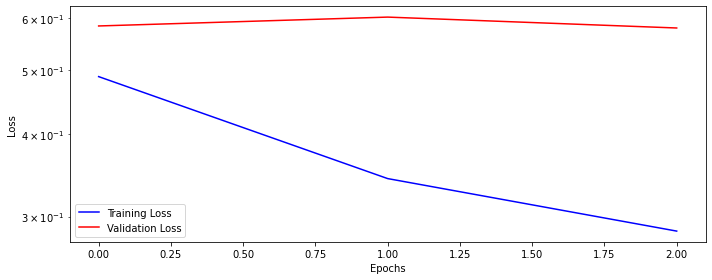

In [ ]:
# set learning class
sbs_alex = StepByStep(alex_top, multi_loss_fn, optimizer_top)
sbs_alex.set_loaders(train_preproc_loader, val_preproc_loader)
# train the model
sbs_alex.train(n_epochs)
sbs_alex.plot_losses()

In [ ]:
# append top layer to the model
AlexNet.classifier[6] = alex_top
print(AlexNet.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=7, bias=True)
  )
)


In [ ]:
results_alex = [correct_sbs(sbs_alex, x, y) for i, (x, y) in enumerate(val_preproc_loader)]
results_alex = torch.stack(results_alex, axis=0)
results_alex = results_alex.sum(axis=0)
results_alex

tensor([[  95,  122],
        [ 715,  786],
        [ 305,  351],
        [1192, 1391],
        [ 732,  797],
        [ 322,  559],
        [ 202,  394]])

In [ ]:
percentage_alex = float(sum(results_alex[:,0])/sum(results_alex[:,1]))
print("succes rate for ResNet:\t{:.2f} %".format(percentage_alex*100))

succes rate for ResNet:	80.98 %


## VGG transfer learning

In [ ]:
# settings
batch_size = 8
n_epochs = 3
learning_rate = 3e-4

In [ ]:
# freeze models
freeze_model(VGG)

In [ ]:
# define top layer
vgg_top = nn.Sequential(nn.Linear(4096, N))
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_top = optim.Adam(vgg_top.parameters(), lr=learning_rate)

In [ ]:
# load preproccesed data
train_preproc = TensorDataset(*torch.load('/content/drive/MyDrive/SU2-data/VGG19_bn_preproc_train.pth'))
val_preproc = TensorDataset(*torch.load('/content/drive/MyDrive/SU2-data/VGG19_bn_preproc_val.pth'))

# load data to DataLoader
train_preproc_loader = DataLoader(train_preproc, batch_size=batch_size, shuffle=True)
val_preproc_loader = DataLoader(val_preproc, batch_size=batch_size)

epoch:	[1/3]
epoch:	[2/3]
epoch:	[3/3]


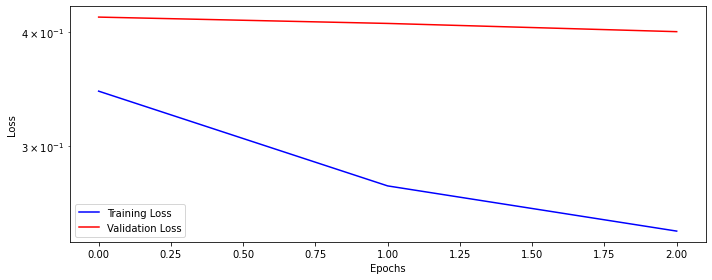

In [ ]:
# set learning class
sbs_vgg = StepByStep(vgg_top, multi_loss_fn, optimizer_top)
sbs_vgg.set_loaders(train_preproc_loader, val_preproc_loader)
# train the model
sbs_vgg.train(n_epochs)
sbs_vgg.plot_losses()

In [ ]:
# append top layer to the model
VGG.classifier[6] = vgg_top
print(VGG.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=7, bias=True)
  )
)


In [ ]:
results_vgg = [correct_sbs(sbs_vgg, x, y) for i, (x, y) in enumerate(val_preproc_loader)]
results_vgg = torch.stack(results_vgg, axis=0)
results_vgg = results_vgg.sum(axis=0)
results_vgg

tensor([[ 105,  122],
        [ 746,  786],
        [ 323,  351],
        [1277, 1391],
        [ 751,  797],
        [ 374,  559],
        [ 242,  394]])

In [ ]:
percentage_vgg = float(sum(results_vgg[:,0])/sum(results_vgg[:,1]))
print("succes rate for ResNet:\t{:.2f} %".format(percentage_vgg*100))

succes rate for ResNet:	86.77 %


## ResNet transfer learning

In [ ]:
# settings
batch_size = 8
n_epochs = 3
learning_rate = 3e-4

In [ ]:
# freeze models
freeze_model(ResNet)

In [ ]:
# define top layer
res_top = nn.Sequential(nn.Linear(512, N))
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_top = optim.Adam(res_top.parameters(), lr=learning_rate)

In [ ]:
# load preproccesed data
train_preproc = TensorDataset(*torch.load('/content/drive/MyDrive/SU2-data/ResNet18_preproc_train.pth'))
val_preproc = TensorDataset(*torch.load('/content/drive/MyDrive/SU2-data/ResNet18_preproc_val.pth'))

# load data to DataLoader
train_preproc_loader = DataLoader(train_preproc, batch_size=batch_size, shuffle=True)
val_preproc_loader = DataLoader(val_preproc, batch_size=batch_size)

epoch:	[1/3]
epoch:	[2/3]
epoch:	[3/3]


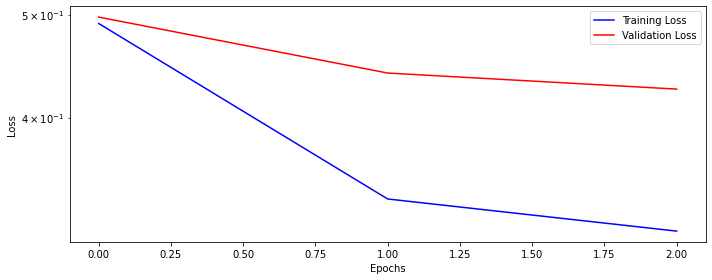

In [ ]:
# set learning class
sbs_res = StepByStep(res_top, multi_loss_fn, optimizer_top)
sbs_res.set_loaders(train_preproc_loader, val_preproc_loader)
# train the model
sbs_res.train(n_epochs)
sbs_res.plot_losses()

In [ ]:
# append top layer to the model
ResNet.fc = res_top
print(ResNet.fc)

Sequential(
  (0): Linear(in_features=512, out_features=7, bias=True)
)


In [ ]:
results_res = [correct_sbs(sbs_res, x, y) for i, (x, y) in enumerate(val_preproc_loader)]
results_res = torch.stack(results_res, axis=0)
results_res = results_res.sum(axis=0)
results_res

tensor([[ 102,  122],
        [ 737,  786],
        [ 316,  351],
        [1253, 1391],
        [ 754,  797],
        [ 368,  559],
        [ 212,  394]])

In [ ]:
percentage_res = float(sum(results_res[:,0])/sum(results_res[:,1]))
print("succes rate for ResNet:\t{:.2f} %".format(percentage_res*100))

succes rate for ResNet:	85.05 %


## DenseNet transfer learning

In [ ]:
# settings
batch_size = 8
n_epochs = 3
learning_rate = 3e-4

In [ ]:
# freeze models
freeze_model(DenseNet)

In [ ]:
# define top layer
dense_top = nn.Sequential(nn.Linear(1024, N))
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_top = optim.Adam(dense_top.parameters(), lr=learning_rate)

In [ ]:
# load preproccesed data
train_preproc = TensorDataset(*torch.load('/content/drive/MyDrive/SU2-data/DenseNet121_preproc_train.pth'))
val_preproc = TensorDataset(*torch.load('/content/drive/MyDrive/SU2-data/DenseNet121_preproc_val.pth'))

# load data to DataLoader
train_preproc_loader = DataLoader(train_preproc, batch_size=batch_size, shuffle=True)
val_preproc_loader = DataLoader(val_preproc, batch_size=batch_size)

epoch:	[1/3]
epoch:	[2/3]
epoch:	[3/3]


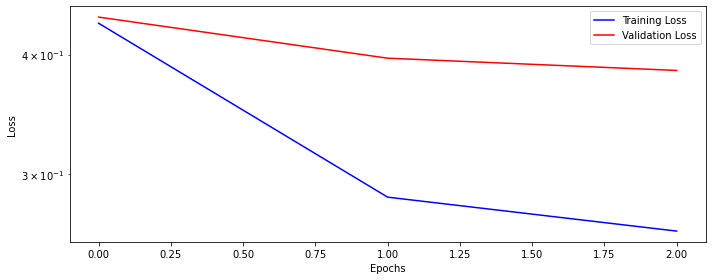

In [ ]:
# set learning class
sbs_dense = StepByStep(dense_top, multi_loss_fn, optimizer_top)
sbs_dense.set_loaders(train_preproc_loader, val_preproc_loader)
# train the model
sbs_dense.train(n_epochs)
sbs_dense.plot_losses()

In [ ]:
# append top layer to the model
DenseNet.classifier = dense_top
print(DenseNet.classifier)

Sequential(
  (0): Linear(in_features=1024, out_features=7, bias=True)
)


In [ ]:
results_dense = [correct_sbs(sbs_dense, x, y) for i, (x, y) in enumerate(val_preproc_loader)]
results_dense = torch.stack(results_dense, axis=0)
results_dense = results_dense.sum(axis=0)
results_dense

tensor([[ 103,  122],
        [ 748,  786],
        [ 324,  351],
        [1280, 1391],
        [ 760,  797],
        [ 369,  559],
        [ 236,  394]])

In [ ]:
percentage_dense = float(sum(results_dense[:,0])/sum(results_dense[:,1]))
print("succes rate for DenseNet:\t{:.2f} %".format(percentage_dense*100))

succes rate for DenseNet:	86.82 %


## Recall of transfer learning

Succes rate for each model:

In [ ]:
print("AlexNet:\t{:.2f} %".format(percentage_alex*100))
print("VGG:\t\t{:.2f} %".format(percentage_vgg*100))
print("ResNet:\t\t{:.2f} %".format(percentage_res*100))
print("AlexNet:\t{:.2f} %".format(percentage_dense*100))

AlexNet:	80.98 %
VGG:		86.77 %
ResNet:		85.05 %
AlexNet:	86.82 %


# Model combination

In [ ]:
# required means and stds
normalizer = Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
# data modification before validation
composer = Compose([Resize(256),
                    CenterCrop(224),
                    ToTensor(),
                    normalizer])
val_data = ImageFolder(root='/content/drive/MyDrive/SU2-data/test', transform=composer)
val_loader = DataLoader(val_data, batch_size=16)

In [ ]:
# calculation of succes rate
def calc_percentage(y_hat, y_true):
  y_hat = np.array(y_hat)
  y_true = np.array(y_true)
  result = []
  for c in range(N):
        # how many ground truth items belong to class "c"
        n_class = sum(y_true == c)
        # how many true "c" items were classified as "c"
        n_correct = sum(y_hat[y_true == c] == c)
        result.append((n_correct, n_class))

  percentage = sum(y_hat == y_true) / len(y_true)
  return [result, percentage]

In [ ]:
def combo(data):
  y_hat = []      # predicted
  y_true = []     # ground truth
  # for each batch
  for i, (x, y) in enumerate(data):
    predicted_combo = []
    # for each model
    for model in models:
      device = next(model.parameters()).device
      model.eval()
      yhat = model(x.to(device))
      model.train()

      # We get the size of the batch and the number of classes 
      _, n_dims = yhat.shape
      # get the most probability class
      _, predicted = torch.max(yhat, 1)
      predicted_combo.append(predicted.numpy())

    # now we have prediction from four models
    # we choose final prediction by mode statistics
    y_hat.extend(stats.mode(predicted_combo)[0][0])
    y_true.extend(y.numpy())

    print("state:\t[{}/{}]".format(i, len(data)))

  return calc_percentage(y_hat, y_true)

In [ ]:
result, percetange = combo(val_loader)

In [ ]:
"""df = pd.DataFrame(result,
                  columns = ["predicted", "ground truth"],
                  index = ["bycicle", "boat", "bus", "car", "van", "motorcycle", "truck"]
                  )
df["succes percentage"] = round(df.iloc[:,0]/df.iloc[:,1]*10000)/100
print(df)"""

In [ ]:
print("succes rate:\t{:.2f}".format(percetange*100))

succes rate:	94.32


**The final model composed from AlexNet, VGG, ResNet, DenseNet has above 90 % succes rate.**